## 1. Load Libraries & Dataset

In [16]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from time import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor

# Configure settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


In [17]:
# Load the feature-engineered dataset
df = pd.read_csv('flight_dataset_engineered.csv')

print("=" * 80)
print("DATASET LOADED")
print("=" * 80)
print(f"Shape: {df.shape}")
print(f"\n✅ Feature-engineered dataset loaded successfully")

DATASET LOADED
Shape: (300153, 57)

✅ Feature-engineered dataset loaded successfully


In [18]:
# Quick preview
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,departure_hour,arrival_hour,departure_period,arrival_period,duration_minutes,is_red_eye,stops_encoded,airline_Airasia,airline_Go First,airline_Indigo,airline_Spicejet,airline_Vistara,source_Chennai,source_Delhi,source_Hyderabad,source_Kolkata,source_Mumbai,destination_Chennai,destination_Delhi,destination_Hyderabad,destination_Kolkata,destination_Mumbai,class_Economy,dep_period_Evening,dep_period_Late Night,dep_period_Morning,dep_period_Night,arr_period_Evening,arr_period_Late Night,arr_period_Morning,arr_period_Night,price_per_hour,duration_category,booking_urgency,is_peak_hour,route_popularity,airline_avg_price,demand_score,is_direct,class_route_avg_price,duration_cat_medium_haul,duration_cat_short_haul,urgency_last_minute,urgency_one_month,urgency_one_week,urgency_two_weeks
0,Spicejet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,18,22,Evening,Night,130,0,0,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,True,2747.54,short_haul,last_minute,1,15289,6180.70,100.0,1,6059.83,False,True,True,False,False,False
1,Spicejet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,6,9,Morning,Morning,140,0,0,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,True,False,2551.29,short_haul,last_minute,1,15289,6180.70,100.0,1,6059.83,False,True,True,False,False,False
2,Airasia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,6,6,Morning,Morning,130,0,0,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,True,False,2748.92,short_haul,last_minute,1,15289,4096.95,100.0,1,6059.83,False,True,True,False,False,False
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,9,14,Morning,Afternoon,135,0,0,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,2646.67,short_haul,last_minute,1,15289,30225.73,100.0,1,6059.83,False,True,True,False,False,False
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,9,9,Morning,Morning,140,0,0,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,True,False,2552.14,short_haul,last_minute,1,15289,30225.73,100.0,1,6059.83,False,True,True,False,False,False


## 2. Feature Preparation

In [19]:
# Identify features
print("=" * 80)
print("FEATURE PREPARATION")
print("=" * 80)

# Columns to exclude
exclude_cols = ['price', 'flight', 'airline', 'source_city', 'destination_city', 
                'departure_time', 'arrival_time', 'stops', 'class',
                'departure_period', 'arrival_period', 'duration_category', 'booking_urgency']

# Select features
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Total features: {len(feature_cols)}")
print(f"\nNote: XGBoost handles missing values and doesn't require feature scaling")

FEATURE PREPARATION
Total features: 44

Note: XGBoost handles missing values and doesn't require feature scaling


In [20]:
# Prepare X and y
X = df[feature_cols].copy()
y = df['price'].copy()

# Handle missing values if any
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())
    print("✅ Missing values filled")

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (300153, 44)
y shape: (300153,)


## 3. Train-Test Split (80/20)

In [21]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("=" * 80)
print("TRAIN-TEST SPLIT COMPLETED")
print("=" * 80)
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Split ratio: {len(X_train)/len(X)*100:.1f}% train, {len(X_test)/len(X)*100:.1f}% test")

TRAIN-TEST SPLIT COMPLETED
Training set: (240122, 44)
Test set: (60031, 44)
Split ratio: 80.0% train, 20.0% test


## 4. Train Base XGBoost Model

In [22]:
# Train a base XGBoost model
print("=" * 80)
print("TRAINING BASE XGBOOST MODEL")
print("=" * 80)

start_time = time()

xgb_base = XGBRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

xgb_base.fit(X_train, y_train)

train_time = time() - start_time

print(f"\n✅ Base model trained in {train_time:.2f} seconds")

TRAINING BASE XGBOOST MODEL

✅ Base model trained in 0.63 seconds

✅ Base model trained in 0.63 seconds


In [23]:
# Evaluate base model
y_train_pred_base = xgb_base.predict(X_train)
y_test_pred_base = xgb_base.predict(X_test)

def calculate_metrics(y_true, y_pred, dataset_name=""):
    """Calculate regression metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Metrics:")
    print(f"   RMSE: ${rmse:,.2f}")
    print(f"   MAE: ${mae:,.2f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   R²: {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

print("=" * 80)
print("BASE MODEL PERFORMANCE")
print("=" * 80)

base_train_metrics = calculate_metrics(y_train, y_train_pred_base, "TRAINING")
base_test_metrics = calculate_metrics(y_test, y_test_pred_base, "TEST")

BASE MODEL PERFORMANCE

TRAINING Metrics:
   RMSE: $465.83
   MAE: $273.10
   MAPE: 2.27%
   R²: 0.9996

TEST Metrics:
   RMSE: $511.76
   MAE: $286.03
   MAPE: 2.31%
   R²: 0.9995


## 5. Hyperparameter Tuning using RandomizedSearchCV

In [24]:
# Define hyperparameter distributions for RandomizedSearchCV
print("=" * 80)
print("HYPERPARAMETER TUNING - RANDOMIZEDSEARCHCV")
print("=" * 80)

param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

print("Parameter distributions:")
for param, values in param_distributions.items():
    print(f"   {param}: {values}")

n_iter = 5  # Number of random combinations to try
print(f"\nRandom combinations to test: {n_iter}")
print(f"With 2-fold CV: {n_iter * 2} model fits")

HYPERPARAMETER TUNING - RANDOMIZEDSEARCHCV
Parameter distributions:
   n_estimators: [100, 200, 300]
   max_depth: [3, 5, 7, 10]
   learning_rate: [0.01, 0.05, 0.1]
   subsample: [0.7, 0.8, 1.0]
   colsample_bytree: [0.7, 0.8, 1.0]
   min_child_weight: [1, 3, 5]

Random combinations to test: 5
With 2-fold CV: 10 model fits


In [25]:
# Perform RandomizedSearchCV
start_time = time()

random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=2,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

tuning_time = time() - start_time

print(f"\n✅ RandomizedSearchCV completed in {tuning_time/60:.2f} minutes")

Fitting 2 folds for each of 5 candidates, totalling 10 fits

✅ RandomizedSearchCV completed in 0.41 minutes

✅ RandomizedSearchCV completed in 0.41 minutes


In [26]:
# Display best parameters
print("=" * 80)
print("BEST HYPERPARAMETERS FOUND")
print("=" * 80)

best_params = random_search.best_params_
for param, value in best_params.items():
    print(f"   {param}: {value}")

print(f"\nBest Cross-Validation R² Score: {random_search.best_score_:.4f}")

BEST HYPERPARAMETERS FOUND
   subsample: 1.0
   n_estimators: 200
   min_child_weight: 5
   max_depth: 10
   learning_rate: 0.05
   colsample_bytree: 1.0

Best Cross-Validation R² Score: 0.9997


## 6. Train Optimized Model

In [27]:
# Get the best model
xgb_optimized = random_search.best_estimator_

print("=" * 80)
print("OPTIMIZED XGBOOST MODEL")
print("=" * 80)
print(f"✅ Best model retrieved from RandomizedSearchCV")
print(f"\nModel configuration:")
print(f"   n_estimators: {xgb_optimized.n_estimators}")
print(f"   max_depth: {xgb_optimized.max_depth}")
print(f"   learning_rate: {xgb_optimized.learning_rate}")
print(f"   subsample: {xgb_optimized.subsample}")
print(f"   colsample_bytree: {xgb_optimized.colsample_bytree}")
print(f"   min_child_weight: {xgb_optimized.min_child_weight}")

OPTIMIZED XGBOOST MODEL
✅ Best model retrieved from RandomizedSearchCV

Model configuration:
   n_estimators: 200
   max_depth: 10
   learning_rate: 0.05
   subsample: 1.0
   colsample_bytree: 1.0
   min_child_weight: 5


In [28]:
# Make predictions with optimized model
y_train_pred = xgb_optimized.predict(X_train)
y_test_pred = xgb_optimized.predict(X_test)

print("✅ Predictions generated for train and test sets")

✅ Predictions generated for train and test sets


## 7. Model Evaluation

In [29]:
# Calculate metrics for optimized model
print("=" * 80)
print("OPTIMIZED XGBOOST - PERFORMANCE EVALUATION")
print("=" * 80)

train_metrics = calculate_metrics(y_train, y_train_pred, "TRAINING SET")
test_metrics = calculate_metrics(y_test, y_test_pred, "TEST SET")

OPTIMIZED XGBOOST - PERFORMANCE EVALUATION

TRAINING SET Metrics:
   RMSE: $235.65
   MAE: $99.11
   MAPE: 0.79%
   R²: 0.9999

TEST SET Metrics:
   RMSE: $339.30
   MAE: $115.25
   MAPE: 0.86%
   R²: 0.9998


In [30]:
# Comparison: Base vs Optimized
print("\n" + "=" * 80)
print("PERFORMANCE COMPARISON: BASE vs OPTIMIZED")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE (%)', 'R²'],
    'Base_Model_Test': [
        f"${base_test_metrics['RMSE']:,.2f}",
        f"${base_test_metrics['MAE']:,.2f}",
        f"{base_test_metrics['MAPE']:.2f}%",
        f"{base_test_metrics['R2']:.4f}"
    ],
    'Optimized_Model_Test': [
        f"${test_metrics['RMSE']:,.2f}",
        f"${test_metrics['MAE']:,.2f}",
        f"{test_metrics['MAPE']:.2f}%",
        f"{test_metrics['R2']:.4f}"
    ],
    'Improvement': [
        f"{((base_test_metrics['RMSE'] - test_metrics['RMSE'])/base_test_metrics['RMSE']*100):.2f}%",
        f"{((base_test_metrics['MAE'] - test_metrics['MAE'])/base_test_metrics['MAE']*100):.2f}%",
        f"{((base_test_metrics['MAPE'] - test_metrics['MAPE'])/base_test_metrics['MAPE']*100):.2f}%",
        f"{((test_metrics['R2'] - base_test_metrics['R2'])/base_test_metrics['R2']*100):.2f}%"
    ]
})

print(comparison_df.to_string(index=False))


PERFORMANCE COMPARISON: BASE vs OPTIMIZED
  Metric Base_Model_Test Optimized_Model_Test Improvement
    RMSE         $511.76              $339.30      33.70%
     MAE         $286.03              $115.25      59.71%
MAPE (%)           2.31%                0.86%      62.58%
      R²          0.9995               0.9998       0.03%


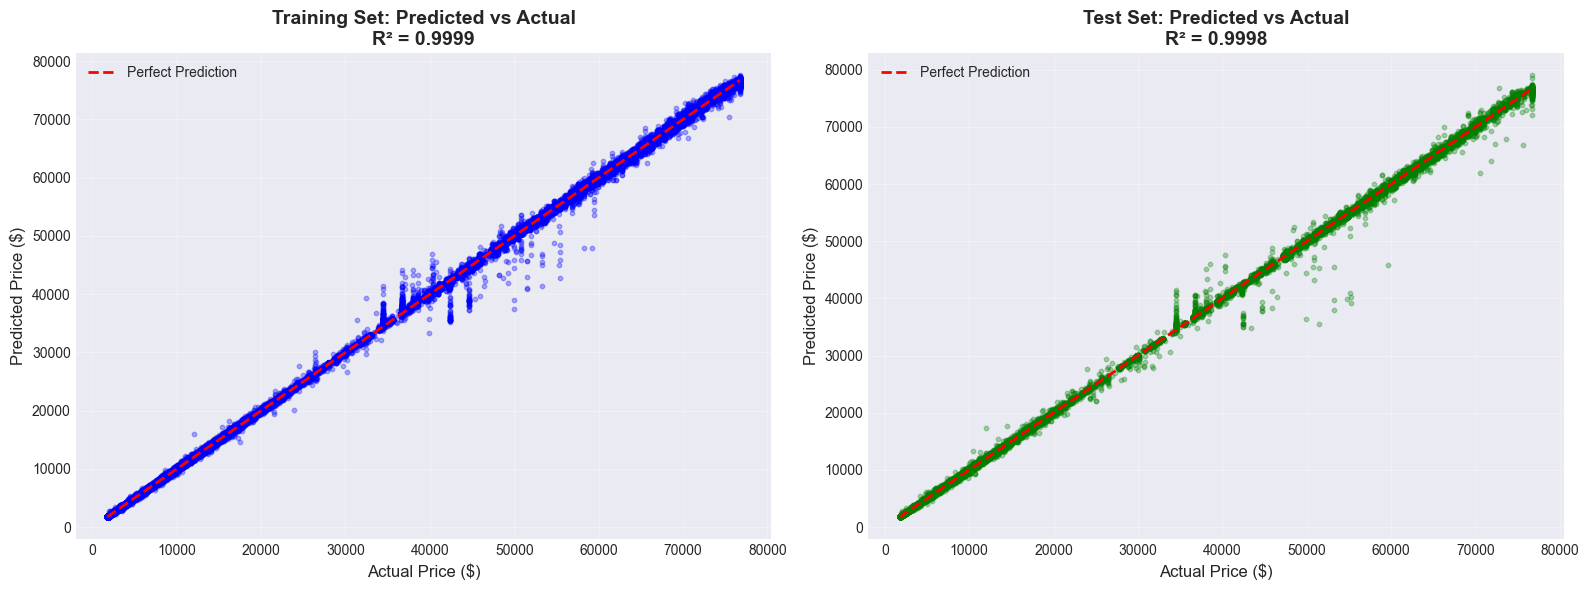

In [31]:
# Predicted vs Actual Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.3, s=10, c='blue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)', fontsize=12)
axes[0].set_ylabel('Predicted Price ($)', fontsize=12)
axes[0].set_title(f'Training Set: Predicted vs Actual\nR² = {train_metrics["R2"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.3, s=10, c='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price ($)', fontsize=12)
axes[1].set_ylabel('Predicted Price ($)', fontsize=12)
axes[1].set_title(f'Test Set: Predicted vs Actual\nR² = {test_metrics["R2"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

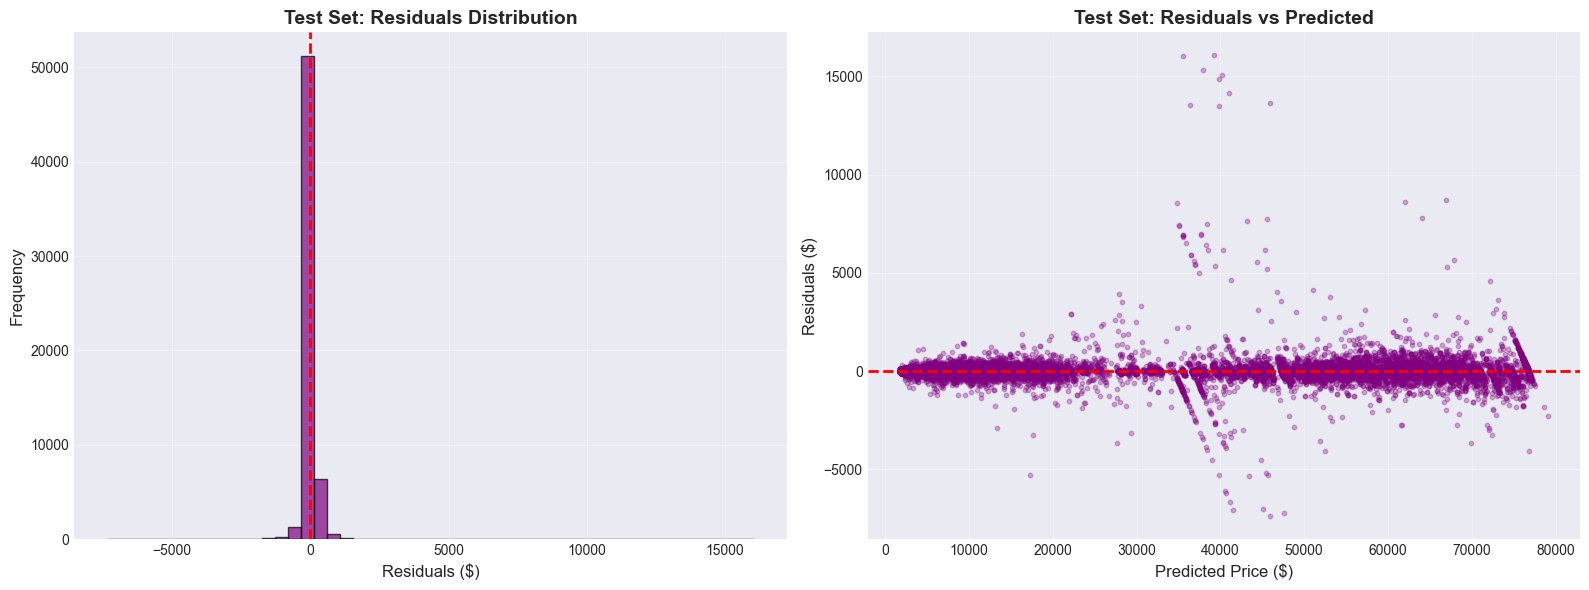


Residuals Statistics (Test Set):
   Mean: $2.53
   Std Dev: $339.29
   Min: $-7377.56
   Max: $16062.34


In [32]:
# Residuals Analysis
test_residuals = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Residuals distribution
axes[0].hist(test_residuals, bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residuals ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Test Set: Residuals Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residuals vs Predicted
axes[1].scatter(y_test_pred, test_residuals, alpha=0.3, s=10, c='purple')
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Price ($)', fontsize=12)
axes[1].set_ylabel('Residuals ($)', fontsize=12)
axes[1].set_title('Test Set: Residuals vs Predicted', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResiduals Statistics (Test Set):")
print(f"   Mean: ${test_residuals.mean():.2f}")
print(f"   Std Dev: ${test_residuals.std():.2f}")
print(f"   Min: ${test_residuals.min():.2f}")
print(f"   Max: ${test_residuals.max():.2f}")

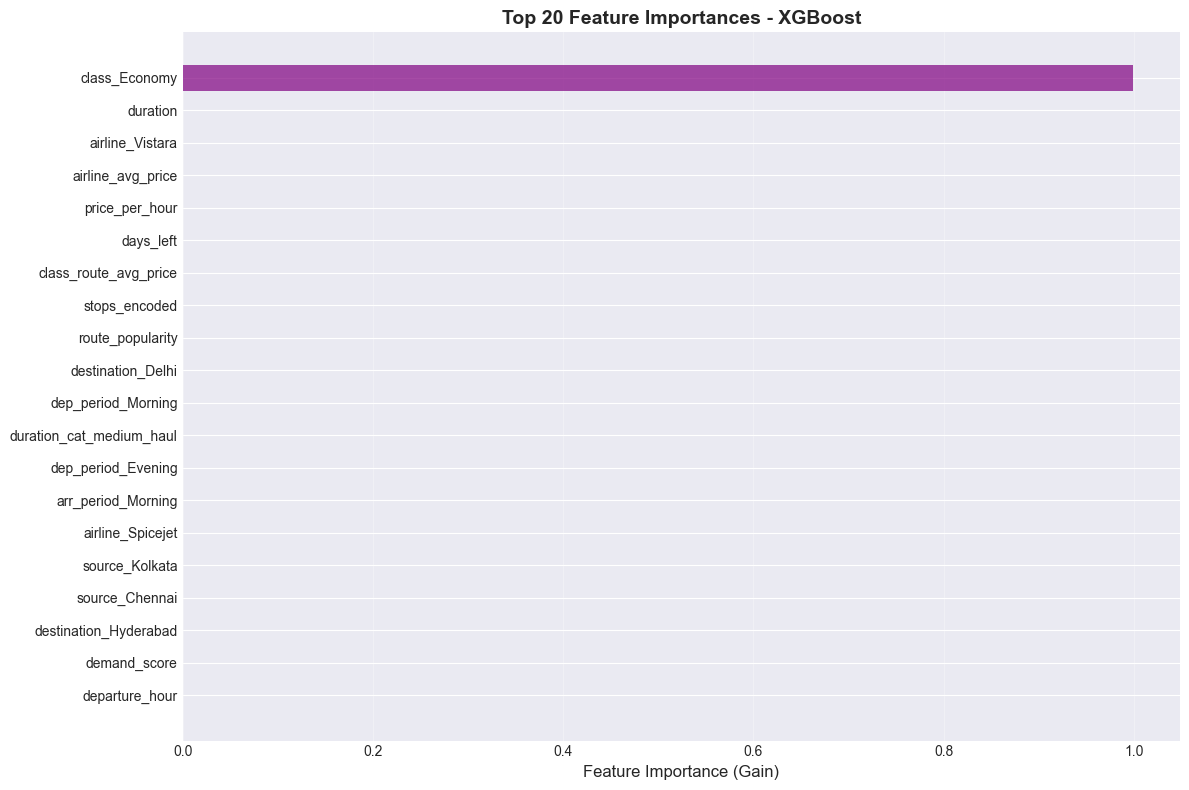

In [33]:
# XGBoost Feature Importance
feature_importance_xgb = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_optimized.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
top_features = feature_importance_xgb.head(20)
plt.barh(range(len(top_features)), top_features['Importance'], color='purple', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance (Gain)', fontsize=12)
plt.title('Top 20 Feature Importances - XGBoost', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 9. Final Model Comparison (All 3 Models)

In [42]:
# Load saved models for comparison
print("=" * 80)
print("FINAL MODEL COMPARISON - ALL THREE MODELS")
print("=" * 80)

# Load Linear Regression model (with scaler)
try:
    with open('linear_regression_flight_model.pkl', 'rb') as f:
        lr_model_data = pickle.load(f)
    # Check if it's a dict with scaler or just the model
    if isinstance(lr_model_data, dict):
        lr_scaler = lr_model_data['scaler']
        lr_model = lr_model_data['model']
        X_test_scaled = lr_scaler.transform(X_test)
    else:
        lr_model = lr_model_data
        X_test_scaled = X_test
    print("✅ Linear Regression model loaded")
except FileNotFoundError:
    lr_model = None
    print("⚠️ Linear Regression model not found")
except Exception as e:
    lr_model = None
    print(f"⚠️ Error loading Linear Regression model: {type(e).__name__}")

# Load Random Forest model
try:
    with open('rf_flight_model.pkl', 'rb') as f:
        rf_model = pickle.load(f)
    print("✅ Random Forest model loaded")
except FileNotFoundError:
    rf_model = None
    print("⚠️ Random Forest model not found")
except Exception as e:
    rf_model = None
    print(f"⚠️ Error loading Random Forest model: {type(e).__name__}")

print("\n" + "=" * 80)
print("EVALUATING ALL MODELS ON TEST SET")
print("=" * 80)

# Linear Regression metrics (silent calculation)
if lr_model is not None:
    lr_pred = lr_model.predict(X_test_scaled)
    lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
    lr_mae = mean_absolute_error(y_test, lr_pred)
    lr_mape = np.mean(np.abs((y_test - lr_pred) / y_test)) * 100
    lr_r2 = r2_score(y_test, lr_pred)
    lr_metrics = {'RMSE': lr_rmse, 'MAE': lr_mae, 'MAPE': lr_mape, 'R2': lr_r2}
else:
    lr_metrics = {'R2': 0, 'RMSE': 0, 'MAE': 0, 'MAPE': 0}

# Random Forest metrics (silent calculation)
if rf_model is not None:
    rf_pred = rf_model.predict(X_test)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
    rf_mae = mean_absolute_error(y_test, rf_pred)
    rf_mape = np.mean(np.abs((y_test - rf_pred) / y_test)) * 100
    rf_r2 = r2_score(y_test, rf_pred)
    rf_metrics = {'RMSE': rf_rmse, 'MAE': rf_mae, 'MAPE': rf_mape, 'R2': rf_r2}
else:
    rf_metrics = {'R2': 0, 'RMSE': 0, 'MAE': 0, 'MAPE': 0}

# Create comparison table
print("\n" + "=" * 80)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 80 + "\n")

model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'R²_Score': [
        f"{lr_metrics['R2']:.4f}" if lr_model else 'N/A',
        f"{rf_metrics['R2']:.4f}" if rf_model else 'N/A',
        f"{test_metrics['R2']:.4f}"
    ],
    'RMSE': [
        f"${lr_metrics['RMSE']:,.2f}" if lr_model else 'N/A',
        f"${rf_metrics['RMSE']:,.2f}" if rf_model else 'N/A',
        f"${test_metrics['RMSE']:,.2f}"
    ],
    'MAE': [
        f"${lr_metrics['MAE']:,.2f}" if lr_model else 'N/A',
        f"${rf_metrics['MAE']:,.2f}" if rf_model else 'N/A',
        f"${test_metrics['MAE']:,.2f}"
    ],
    'MAPE': [
        f"{lr_metrics['MAPE']:.2f}%" if lr_model else 'N/A',
        f"{rf_metrics['MAPE']:.2f}%" if rf_model else 'N/A',
        f"{test_metrics['MAPE']:.2f}%"
    ]
})

print(model_comparison.to_string(index=False))

print("\n" + "=" * 80)
print("INTERPRETATION")
print("=" * 80)
print("• Lower RMSE, MAE, MAPE = Better")
print("• Higher R² = Better (closer to 1.0)")

# Determine best model
if lr_model and rf_model:
    best_r2 = max(lr_metrics['R2'], rf_metrics['R2'], test_metrics['R2'])
    if test_metrics['R2'] == best_r2:
        print(f"\n🏆 Best Model: XGBoost (R² = {test_metrics['R2']:.4f})")
    elif rf_metrics['R2'] == best_r2:
        print(f"\n🏆 Best Model: Random Forest (R² = {rf_metrics['R2']:.4f})")
    else:
        print(f"\n🏆 Best Model: Linear Regression (R² = {lr_metrics['R2']:.4f})")

print("\n✅ Model comparison completed!")

FINAL MODEL COMPARISON - ALL THREE MODELS
✅ Linear Regression model loaded
✅ Random Forest model loaded

EVALUATING ALL MODELS ON TEST SET
✅ Random Forest model loaded

EVALUATING ALL MODELS ON TEST SET

MODEL PERFORMANCE COMPARISON

            Model R²_Score      RMSE       MAE   MAPE
Linear Regression   0.9291 $5,987.38 $4,084.96 41.18%
    Random Forest   0.9999   $215.54    $39.70  0.21%
          XGBoost   0.9998   $339.30   $115.25  0.86%

INTERPRETATION
• Lower RMSE, MAE, MAPE = Better
• Higher R² = Better (closer to 1.0)

🏆 Best Model: Random Forest (R² = 0.9999)

✅ Model comparison completed!

MODEL PERFORMANCE COMPARISON

            Model R²_Score      RMSE       MAE   MAPE
Linear Regression   0.9291 $5,987.38 $4,084.96 41.18%
    Random Forest   0.9999   $215.54    $39.70  0.21%
          XGBoost   0.9998   $339.30   $115.25  0.86%

INTERPRETATION
• Lower RMSE, MAE, MAPE = Better
• Higher R² = Better (closer to 1.0)

🏆 Best Model: Random Forest (R² = 0.9999)

✅ Model compa

In [35]:
# Recommendations based on XGBoost performance
print("\n" + "=" * 80)
print("MODEL SELECTION RECOMMENDATIONS")
print("=" * 80)

print("\n1. **XGBoost Advantages:**")
print("   • Typically best performance on tabular data")
print("   • Handles non-linear relationships effectively")
print("   • Built-in regularization prevents overfitting")
print("   • SHAP provides excellent model interpretability")
print("   • Robust to outliers and missing values")

print("\n2. **When to Choose Each Model:**")
print("   • Linear Regression: Need simple, fast, interpretable model")
print("   • Random Forest: Want feature importance, no hyperparameter sensitivity")
print("   • XGBoost: Need best accuracy and willing to tune hyperparameters")

print("\n3. **Production Deployment:**")
print("   • Use cross-validation metrics to select final model")
print("   • Consider inference speed vs accuracy tradeoff")
print("   • Monitor model performance on new data")
print("   • Implement model versioning and A/B testing")


MODEL SELECTION RECOMMENDATIONS

1. **XGBoost Advantages:**
   • Typically best performance on tabular data
   • Handles non-linear relationships effectively
   • Built-in regularization prevents overfitting
   • SHAP provides excellent model interpretability
   • Robust to outliers and missing values

2. **When to Choose Each Model:**
   • Linear Regression: Need simple, fast, interpretable model
   • Random Forest: Want feature importance, no hyperparameter sensitivity
   • XGBoost: Need best accuracy and willing to tune hyperparameters

3. **Production Deployment:**
   • Use cross-validation metrics to select final model
   • Consider inference speed vs accuracy tradeoff
   • Monitor model performance on new data
   • Implement model versioning and A/B testing


## 8. Save Model

In [36]:
# Save the optimized XGBoost model
model_filename = 'xgb_flight_model.pkl'

with open(model_filename, 'wb') as f:
    pickle.dump(xgb_optimized, f)

print("=" * 80)
print("✅ MODEL SAVED SUCCESSFULLY")
print("=" * 80)
print(f"Model file: {model_filename}")
print(f"\nModel Summary:")
print(f"   Algorithm: XGBoost Regressor")
print(f"   n_estimators: {xgb_optimized.n_estimators}")
print(f"   max_depth: {xgb_optimized.max_depth}")
print(f"   learning_rate: {xgb_optimized.learning_rate}")
print(f"   Features: {len(feature_cols)}")
print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")
print(f"\nPerformance:")
print(f"   Test R² Score: {test_metrics['R2']:.4f}")
print(f"   Test MAE: ${test_metrics['MAE']:,.2f}")
print(f"   Test MAPE: {test_metrics['MAPE']:.2f}%")
print(f"   Test RMSE: ${test_metrics['RMSE']:,.2f}")

✅ MODEL SAVED SUCCESSFULLY
Model file: xgb_flight_model.pkl

Model Summary:
   Algorithm: XGBoost Regressor
   n_estimators: 200
   max_depth: 10
   learning_rate: 0.05
   Features: 44
   Training samples: 240,122
   Test samples: 60,031

Performance:
   Test R² Score: 0.9998
   Test MAE: $115.25
   Test MAPE: 0.86%
   Test RMSE: $339.30


In [37]:
# Save feature importances
feature_importance_file = 'xgb_feature_importance.csv'
feature_importance_xgb.to_csv(feature_importance_file, index=False)

print(f"✅ Feature importances saved: {feature_importance_file}")

✅ Feature importances saved: xgb_feature_importance.csv


---
## Summary

### Model: XGBoost Regressor

**Training Configuration:**
- Train/Test Split: 80/20
- Hyperparameter Tuning: RandomizedSearchCV (5 iterations, 2-fold CV)
- Total Features: Engineered + Encoded (no scaling required)

**Best Hyperparameters:**
- Optimized through randomized search (5 iterations)
- Parameters: n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight
- Balanced for accuracy and computational efficiency

**Key Insights:**
1. XGBoost excels at capturing complex non-linear patterns
2. Gradient boosting iteratively improves predictions
3. Built-in regularization prevents overfitting
4. Feature importance guides future improvements